## <center>Elements Of Data Science - F2023</center>
# <center>Week 8: Data Cleaning and Feature Engineering<center>
### <center>11/11/2024</center>

# TODOs

- Readings:
 - PML Ch4.5 : Selecting Meaningful Features
 - PML Ch5.1 : Unsupervised dimensionality reduction via principal component analysis
 - [Recommended] [Pandas: Merge, join, concatenate and compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#)
 - [Additional] PDSH 5.9 : [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
 - [Optional] : Nice ROC visualization (http://www.navan.name/roc/)

<br>
<br>


# Precision & Recall and ROC visualizations
<table>
<tr>
    <td>Precision & Recall<br><img src="images/Precisionrecall.svg.png" width="400px"><br><font size=4>https://www.wikiwand.com/en/Precision_and_recall</font></td>
    <td>ROC<br><img src="images/roc_cutoff-1.gif"><br>This and more at <a href="https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation">https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation</a><br><br>
    Also see the interactive viz at <a href="http://www.navan.name/roc/">http://www.navan.name/roc/</a></td>
</tr>
</table>

# Notes from Quiz 7

- LinearRegression (regression) vs LogisticRegression (classification)

- using a model "with default settings"

In [1]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

# Today

- **Data Cleaning**
 - Duplicates
 - Missing Data
 - Dummy Variables
 - Rescaling
 - Dealing With Skew
 - Removing Outliers
<br>

- **Feature Engineering**
 - Binning
 - One-Hot encoding
 - Derived
   - string functions
   - datetime functions


<br>
<br>

# <center>Questions?</center>
<br>
<br>

# Environment Setup

In [2]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

sns.set_style('darkgrid')

%matplotlib inline

# Data Cleaning
<br>

Why do we need clean data?

- **To remove duplicates** Want one row per observation
- **To remove/fill missing** Most models cannot handle missing data 
- **To engineer features** Most models require fixed length feature vectors 
<br>

- Different models require different types of data (transformation)
 - **Linear models**: real valued features with similar scale
 - **Distance based**: real valued features with similar scale
 - **Tree based**: can handle unscaled real and categorical (sklearn requires real)

# Example Data

In [3]:
# read in example data
df_shop_raw = pd.read_csv('../data/flowershop_data_with_dups_week8.csv',
                          header=0,
                          delimiter=',')
df_shop_raw['purchase_date'] = pd.to_datetime(df_shop_raw.purchase_date)

# make a copy for editing
df_shop = df_shop_raw.copy()

df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      1001 non-null   int64         
 1   lastname         1001 non-null   object        
 2   purchase_date    1001 non-null   datetime64[ns]
 3   stars            1001 non-null   int64         
 4   price            979 non-null    float64       
 5   favorite_flower  823 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 47.0+ KB


# Duplicated Data
<br>
    
- Only drop duplicates if you know data should be unique
 - Example: if there is a unique id per row

In [4]:
df_shop.duplicated().iloc[-3:] # are any of the last 3 rows duplicates?

998     False
999     False
1000     True
dtype: bool

In [5]:
df_shop[df_shop.duplicated(keep='first')] # default: keep 'first' duplicated row

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil


In [6]:
df_shop[df_shop.duplicated(keep=False)] # keep=False to show all duplicated rows

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
10,1010,FERGUSON,2017-05-04,2,21.02,daffodil
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil


# Duplicated Data for Subset of Columns

In [7]:
# if it's important that a subset of columns is not duplicated
(
    df_shop
    .sort_values(by='purchase_id')
    .loc[df_shop.duplicated(subset=['purchase_id'],keep='first')]
    
)

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil
101,1101,BURKE,2017-08-16,4,18.56,daffodil


In [8]:
# could also use the indexing shortcut
df_shop[df_shop.duplicated(subset=['purchase_id'],keep='first')].sort_values(by='purchase_id')

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil
101,1101,BURKE,2017-08-16,4,18.56,daffodil


# Dropping Duplicates

In [9]:
df_shop = df_shop.drop_duplicates(subset=None,    # consider all columns
                                  keep='first',   # or 'last' or False)
                                  inplace=False   # default, return a modified dataframe
                                 )

In [10]:
# or can use inplace to change the original dataframe
df_shop.drop_duplicates(subset=None,
                        keep='first',
                        inplace=True # change the dataframe in place
                       )

In [11]:
# can also drop rows with duplicates considering only a subset of columns
df_shop = df_shop.drop_duplicates(subset=['purchase_id'])

# Missing Data

- Reasons for missing data
 - Sensor error (random?)
 - Data entry error (random?)
 - Survey-subject decisions (non-random?)
 - etc.
<br>

- Dealing with missing data
 - Drop rows
 - Impute from data in the same column
 - Infer from other features
 - Fill with adjacent data

# Missing Data in Pandas: `np.nan`
<br>

- Missing values represented by `np.nan` : Not A Number

In [12]:
# Earlier, we saw missing values in the dataframe summary
# df_shop.info()

In [13]:
# can we check for NaN using "x == np.nan"? No!
np.nan == np.nan


False

`==` operator compares the values of both the operands and checks for value equality. *`is` operator*, on the other hand, checks whether both the operands refer to the same object or not.

In [14]:
# however
np.nan is np.nan

True

In [15]:
a = np.nan
b = np.nan

In [16]:
id(a)

140603883569936

In [17]:
id(b)

140603883569936

# How to check for NaN: `.isna()` and `.notna()`

In [18]:
# some missing data
df_shop.loc[20:21,'price']

20      NaN
21    10.53
Name: price, dtype: float64

In [19]:
# .isna() returns True where data is missing, False otherwise
df_shop.loc[20:21,'price'].isna()

20     True
21    False
Name: price, dtype: bool

In [20]:
# .notna() returns True where data is NOT missing, False otherwise
df_shop.loc[20:21,'price'].notna()

20    False
21     True
Name: price, dtype: bool

In [21]:
# find rows where price is missing
df_shop[df_shop.price.isna()].head()

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
20,1020,CLARK,2017-01-05,3,NaN,NaN
41,1041,PETERS,2017-02-01,4,NaN,orchid
54,1054,GREEN,2017-02-13,5,NaN,daffodil
63,1063,BARNETT,2017-08-27,4,NaN,gardenia
145,1145,CARROLL,2017-07-29,3,NaN,tulip


# Counting NaNs

In [22]:
# How many nan's in a single column?
df_shop.price.isna().sum()

22

In [23]:
# How many nan's per column?
df_shop.isna().sum()

purchase_id          0
lastname             0
purchase_date        0
stars                0
price               22
favorite_flower    178
dtype: int64

In [24]:
# How many total nan's?
df_shop.isna().sum().sum()

200

# Missing Data: Drop Rows

In [25]:
df_shop.shape

(999, 6)

In [26]:
# drop rows with nan in any column
df_shop.dropna().shape

(801, 6)

In [27]:
# drop only rows with nan in price using subset
df_shop.dropna(subset=['price']).shape

(977, 6)

In [28]:
# drop only rows with nans in all columns (a row of all nans)
df_shop.dropna(how='all').shape

(999, 6)

# Missing Data: Drop Rows Cont.

In [29]:
# save a new dataframe with dropped rows
df_shop = df_shop_raw.dropna().copy()
df_shop.shape

(803, 6)

In [30]:
# drop rows in current dataframe with inplace
df_shop = df_shop_raw.copy()

df_shop.dropna(inplace=True)
df_shop.shape

(803, 6)

# Missing Data: Drop Rows
<br>

- Pros:
 - easy to do
 - simple to understand
<br>
<br>

- Cons:
 - potentially large data loss

# Missing Data: Fill with Constant

- Use .fillna()
- Common filler: 0, -1

In [31]:
df_shop = df_shop_raw.drop_duplicates().copy() # make a new copy of the data

In [32]:
df_shop.price[20:22]

20      NaN
21    10.53
Name: price, dtype: float64

In [33]:
df_shop.price[20:22].fillna(0)

20     0.00
21    10.53
Name: price, dtype: float64

In [34]:
print(df_shop.price.mean().round(2))
print(df_shop.price.fillna(0).mean().round(2))

23.4
22.89


# Missing Data: Fill with Constant

Pros:

- easy to do
- simple to understand

Cons:

- values may not be realistic

# Missing Data: Impute
<br>

- Impute: fill with value infered from existing values in that column
<br>

- Use .fillna() or sklearn methods
<br>

- Common filler values:
 - mean
 - median
 - "most frequent" aka mode

# Missing Data: Impute

In [35]:
print(df_shop.price.mean().round(2))
print(df_shop.price.fillna(df_shop.price.mean()).mean().round(2))

23.4
23.4


In [36]:
# make a copy to keep our original df
df_shop_impute = df_shop.copy()

In [37]:
# fill missing price with mean of price
df_shop_impute['price'] = df_shop.price.fillna(df_shop.price.mean())

In [38]:
# check to make sure all nulls filled
assert df_shop_impute.price.isna().sum() == 0
assert df_shop_impute.price.notna().all()

# also, that our mean hasn't changed
assert df_shop.price.mean() == df_shop_impute.price.mean() 

In [39]:
# inplace works here as well
df_shop_impute.price.fillna(df_shop_impute.price.mean(),inplace=True)

# Missing Data: Impute Cont.
#### if data is cathegorical?

In [40]:
df_shop.favorite_flower.mode() # may be more than 1!

0    lilac
Name: favorite_flower, dtype: object

In [41]:
# Note that we have to index into the DataFrame returned by mode to get a value
df_shop_impute.favorite_flower.fillna(df_shop_impute.favorite_flower.mode().iloc[0],inplace=True)

df_shop_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      1000 non-null   int64         
 1   lastname         1000 non-null   object        
 2   purchase_date    1000 non-null   datetime64[ns]
 3   stars            1000 non-null   int64         
 4   price            1000 non-null   float64       
 5   favorite_flower  1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 87.0+ KB


# Missing Data: Impute Cont. Using SimpleImputer

In [42]:
df_shop[['price','stars']].loc[20:22]

,price,stars
20,NaN,3
21,10.53,2
22,19.77,1


In [43]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean').fit(df_shop[['price','stars']])
print(f'fill values = {imp.statistics_.round(2)}')
imp.transform(df_shop.loc[20:22,['price','stars']]).round(2)

fill values = [23.4  3.6]


array([[23.4 ,  3.  ],
       [10.53,  2.  ],
       [19.77,  1.  ]])

In [44]:
df_shop.favorite_flower[:3]

0         iris
1          NaN
2    carnation
Name: favorite_flower, dtype: object

In [45]:
imp = SimpleImputer(strategy='most_frequent').fit(df_shop[['favorite_flower']])
imp.transform(df_shop.loc[:2,['favorite_flower']])

array([['iris'],
       ['lilac'],
       ['carnation']], dtype=object)

# Missing Data: Impute
<br>

- Pros:
 - easy to do
 - simple to understand
<br>
<br>

- Cons:
 - may missing feature interactions

# Missing Data: Infer
<br>

- Predict values of missing features using a model
- Ex: Can we predict price based on any of the other features?
- Additional feature engineering may be needed prior to this

In [46]:
from sklearn.linear_model import LinearRegression

df_shop_infer = df_shop.copy()

not_missing = df_shop_infer.price.notna()
missing     = df_shop_infer.price.isna()

lr = LinearRegression().fit(df_shop_infer.loc[not_missing,['stars']],
                            df_shop_infer.loc[not_missing,'price'])

df_shop_infer.loc[missing,'price'] = lr.predict(df_shop_infer.loc[missing,['stars']])

# Missing Data: Infer

<br>

- Pros:
 - better estimate (based on other data)
<br>
<br>

- Cons:
 - have to train another model
 - colinear features!

# Missing Data: Adjacent Data
<br>

- Use `.fillna()` with method:
 - ffill: propagate last valid observation forward to next valid
 - bfill: use next valid observation to fill gap backwards
<br>

- Use when there is reason to believe data not i.i.d. (eg: **timeseries**)

In [47]:
df_shop.price.loc[19:21]

19    20.45
20      NaN
21    10.53
Name: price, dtype: float64

In [48]:
df_shop.price.fillna(method='ffill').loc[19:21]

19    20.45
20    20.45
21    10.53
Name: price, dtype: float64

# Missing Data: Add a Dummy Column First
<br>

- Data may be missing for a reason!
- Capture "missing" before filling

In [49]:
df_shop = df_shop_raw.drop_duplicates().copy()

# storing a column of 1:missing, 0:not-missing
df_shop['price_missing'] = df_shop.price.isna().astype(int)

# can now fill missing values
df_shop['price'] = df_shop.price.fillna(df_shop.price.mean())

In [50]:
# finding where data was missing
np.where(df_shop.price_missing == 1)

(array([ 20,  41,  54,  63, 145, 186, 194, 203, 212, 360, 367, 382, 429,
        469, 522, 570, 595, 726, 792, 821, 974, 978]),)

In [51]:
df_shop[['price','price_missing']].iloc[20:23]

,price,price_missing
20,23.403384,1
21,10.530000,0
22,19.770000,0


# Rescaling
<br>

- Often need features to be in the same scale
- Methods of rescaling
 - Standardization (z-score)
 - Min-Max rescaling
 - others...

In [52]:
# load taxi data
df_taxi_raw = pd.read_csv('../data/yellowcab_tripdata_2017-01_subset10000rows.csv',
                          parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])
# create trip_duration
df_taxi_raw['trip_duration'] = (df_taxi_raw.tpep_dropoff_datetime - df_taxi_raw.tpep_pickup_datetime).dt.seconds

# select subset
df_taxi_raw = df_taxi_raw[df_taxi_raw.trip_duration.lt(3600) & 
                          df_taxi_raw.tip_amount.between(0,10,inclusive='neither')]
                           
df_taxi = df_taxi_raw.copy()

In [53]:
df_taxi[['trip_duration','tip_amount']].agg(['mean','std','min','max'],axis=0).round(2)

,trip_duration,tip_amount
mean,765.03,2.41
std,496.83,1.55
min,2.00,0.01
max,3556.00,9.99


# Rescaling: Standardization
<br>

- rescale to 0 mean, standard deviation of 1
 - X_scaled = (X - X.mean()) / X.std()

In [54]:
from sklearn.preprocessing import StandardScaler

# instantiate
ss = StandardScaler(with_mean=True, with_std=True) # default is center and scale

# fit to the data
ss.fit(df_taxi[['trip_duration','tip_amount']])

# transform the data
X_ss = ss.transform(df_taxi[['trip_duration','tip_amount']])
X_ss[:2].round(2)

array([[-0.5 , -0.48],
       [-0.17, -0.91]])

In [55]:
df_taxi_ss = pd.DataFrame(X_ss,columns=['trip_duration_scaled','tip_amount_scaled'])
df_taxi_ss.agg(['mean','std','min','max'],axis=0).round(2)

,trip_duration_scaled,tip_amount_scaled
mean,0.00,-0.00
std,1.00,1.00
min,-1.54,-1.54
max,5.62,4.88


# Rescaling: Min-Max

- rescale values between 0 and 1
- X_scaled = (X - X.min()) / (X.max() - X.min())
- removes negative values

In [56]:
from sklearn.preprocessing import MinMaxScaler

X_mms = MinMaxScaler(feature_range=(0,1) # default is to rescale between 0 and 1
                    ).fit_transform(df_taxi[['trip_duration','tip_amount']])

df_taxi_mms = pd.DataFrame(X_mms,columns=['trip_duration_scaled','tip_amount_scaled'])
df_taxi_mms.agg(['mean','std','min','max']).round(2)

,trip_duration_scaled,tip_amount_scaled
mean,0.21,0.24
std,0.14,0.16
min,0.00,0.00
max,1.00,1.00


# Dealing with Skew
<br>

- Many models expect "normal", symmetric data (ex: linear models)
- Highly skewed: tail has larger effect on model (outliers?)
- Transform with `log` or `sqrt`


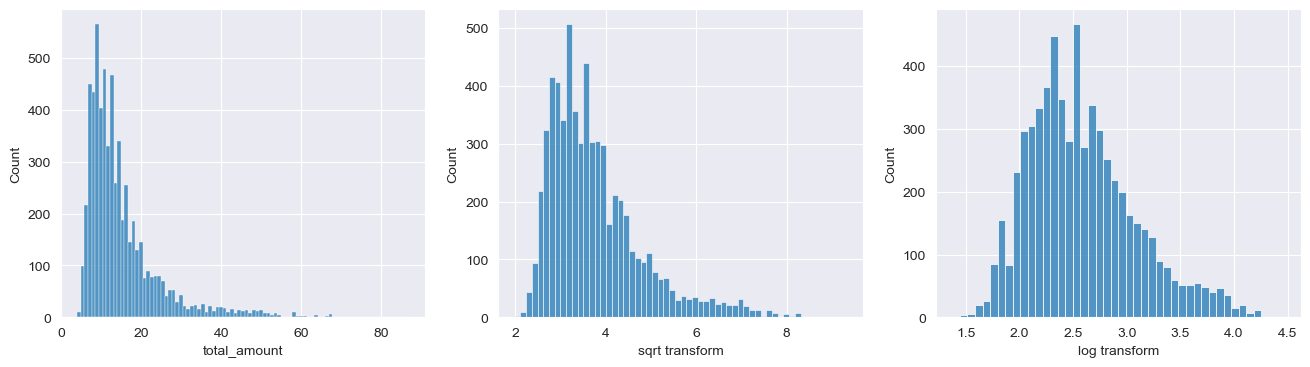

In [57]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
sns.histplot(x=df_taxi.total_amount, ax=ax[0]);
sns.histplot(x=df_taxi.total_amount.apply(np.sqrt), ax=ax[1]); ax[1].set_xlabel('sqrt transform');
sns.histplot(x=df_taxi.total_amount.apply(np.log),  ax=ax[2]); ax[2].set_xlabel('log transform');

# Outliers

- Similar to missing data:
 - human data entry error
 - instrument measurement errors
 - data processing errors
 - natural deviations


<div align="center"><img src="images/outlier-detection-1.png" width="600px"></div>

# Outliers
<br>

- Why worry about them?
 - can give misleading results
 - can indicate issues in data/measurement
<br>
<br>

- Detecting Outliers
 - understand your data!
 - visualizations
 - 1.5*IQR
 - z-scores
 - etc..

# Detecting Outliers

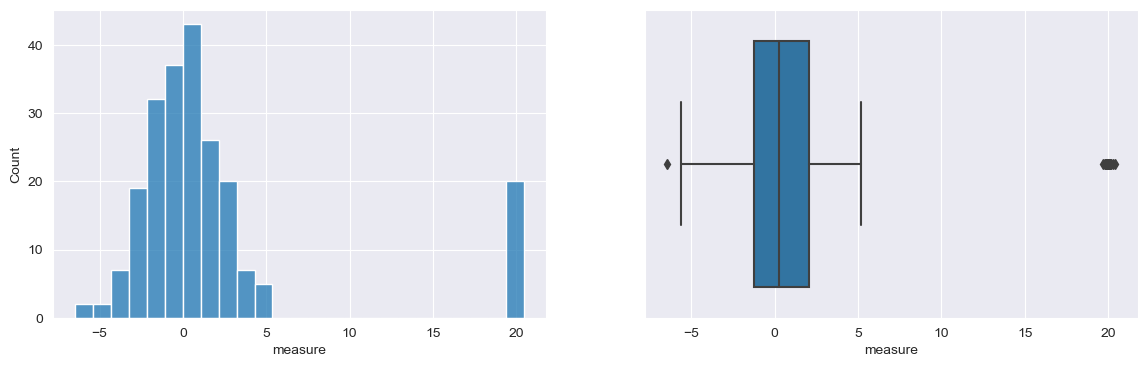

In [58]:
np.random.seed(123)
data_rand = np.concatenate([np.random.normal(0,2,200),np.random.normal(20,.2,20)])
df_rand = pd.DataFrame({'measure':data_rand})

fig,ax = plt.subplots(1,2, figsize=(14,4))
sns.histplot(x=df_rand.measure,ax=ax[0]);sns.boxplot(x=df_rand.measure,ax=ax[1]);

In [59]:
# Calculating IQR
p25,p75 = df_rand.measure.quantile([.25,.75])
iqr = p75 - p25
round(iqr,2)

3.3

In [60]:
# Finding outliers with IQR (first two examples found)
df_rand.measure[(df_rand.measure > p75+(1.5*iqr)) | (df_rand.measure < p25-(1.5*iqr))].sort_values()#.head(2).round(2)

195    -6.462110
213    19.716784
207    19.816939
218    19.847741
214    19.866179
201    19.880379
212    19.945024
205    19.958668
208    19.980959
206    19.982696
204    19.998739
219    20.000729
209    20.055737
217    20.073924
210    20.115908
211    20.115938
203    20.137659
200    20.140662
216    20.179212
215    20.322439
202    20.440140
Name: measure, dtype: float64

# Detecting Outliers with z-score

,measure,measure_zscore
213,19.72,2.93
207,19.82,2.94
218,19.85,2.95


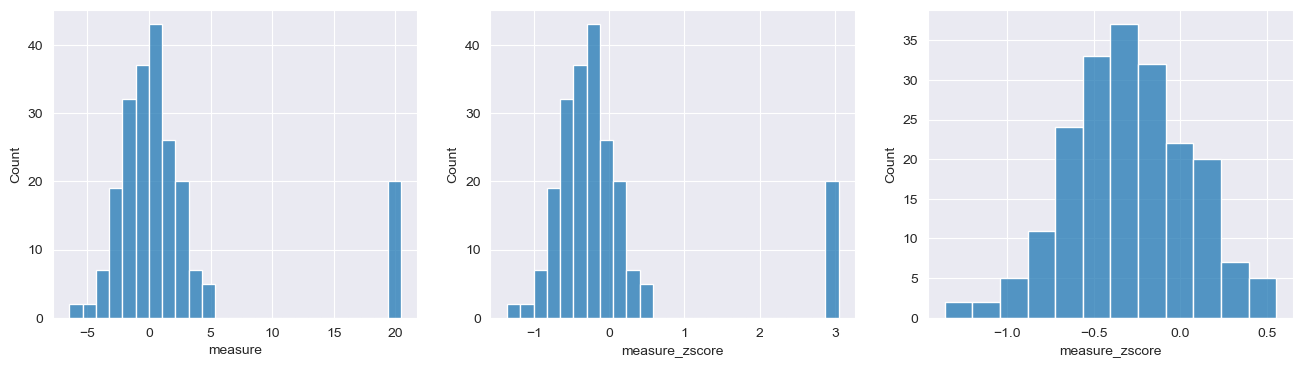

In [61]:
# zscore
df_rand['measure_zscore'] = (df_rand.measure - df_rand.measure.mean()) / df_rand.measure.std()

fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.histplot(x=df_rand.measure,ax=ax[0]);
sns.histplot(x=df_rand.measure_zscore, ax=ax[1]);

keep_idx = np.abs(df_rand.measure_zscore) < 2
sns.histplot(x=df_rand[keep_idx].measure_zscore, ax=ax[2]);

# sample of points getting dropped
df_rand[np.abs(df_rand.measure_zscore) >= 2].sort_values(by='measure').head(3).round(2)

# Other Outlier Detection Methods
<br>

- Many more parametric and non-parametric methods
 - Standardized Residuals
 - DBScan
 - ElipticEnvelope
 - IsolationForest
 - other Anomoly Detection techniques
 - See [sklearn docs on Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html) for more details

# Dealing with Outliers
<br>

- How to deal with outliers?
 - drop data
 - treat as missing
 - encode with dummy variable first

# Putting It All Together: Different Styles

In [62]:
df_shop1 = pd.read_csv('../data/flowershop_data_with_dups_week8.csv')
df_shop1 = df_shop1.drop_duplicates()
df_shop1['purchase_date']           = pd.to_datetime(df_shop1.purchase_date)
df_shop1['price_missing']           = df_shop1.price.isna().astype(int)
df_shop1['price']                   = df_shop1.price.fillna(df_shop1.price.mean())
df_shop1['price_scaled']            = StandardScaler().fit_transform(df_shop1[['price']])
df_shop1['favorite_flower_missing'] = df_shop1.favorite_flower.isna().astype(int)
df_shop1['favorite_flower']         = SimpleImputer(strategy='most_frequent').fit(df_shop1[['favorite_flower']])

In [63]:
df_shop2 = (
    pd.read_csv('../data/flowershop_data_with_dups_week8.csv')
    .drop_duplicates()
    .assign(
        purchase_date           = lambda df_ : pd.to_datetime(df_.purchase_date),
        price_missing           = lambda df_ : df_.price.isna().astype(int),
        price                   = lambda df_ : df_.price.fillna(df_.price.mean()),
        price_scaled            = lambda df_ : StandardScaler().fit_transform(df_[['price']]),
        favorite_flower_missing = lambda df_ : df_.favorite_flower.isna().astype(int),
        favorite_flower         = lambda df_ : (SimpleImputer(strategy='most_frequent')
                                                .fit_transform(df_shop1[['favorite_flower']])
                                               )
    )
)

In [64]:
pd.testing.assert_frame_equal(df_shop1,df_shop2) # throws an exeption when data frames are not the same 

# Data Cleaning Review

- duplicate data
- missing data
- rescaling
- dealing with skew
- outlier detection

# Feature Engineering
<br>

- Binning
- One-Hot encoding
- Derived Features

# Binning
<br>

- Transform continuous features to categorical
- Use:
 - pd.cut
 - sklearn.preprocessing.KBinsDiscretizer (combined binning and one-hot-encoding)

In [65]:
trip_duration_bins = [df_taxi.trip_duration.min(),
                      df_taxi.trip_duration.median(),
                      df_taxi.trip_duration.quantile(0.75),
                      df_taxi.trip_duration.max(),]

In [66]:
df_taxi_bin = df_taxi_raw.copy()
df_taxi_bin['trip_duration_binned'] = pd.cut(df_taxi_bin.trip_duration,           
                                             bins=trip_duration_bins,          # can pass bin edges or number of bins
                                             labels=['short','medium','long'],
                                             right=True,                       # all bins right-inclusive
                                             include_lowest=True               # first interval left-inclusive
                                            )
df_taxi_bin[['trip_duration','trip_duration_binned']].iloc[:10]


,trip_duration,trip_duration_binned
1,516,short
2,683,medium
7,834,medium
8,298,short
12,396,short
13,1053,long
14,616,short
15,1493,long
16,874,medium
17,409,short


# One-Hot Encoding

- Encode categorical features for models that can't handle categorical (eg. Linear)
- One column per category, '1' in only one column per row
- Use `pd.get_dummies()` or `sklearn.preprocessing.OneHotEncoder`

In [67]:
pd.get_dummies(df_taxi_bin.trip_duration_binned, prefix='trip_duration').iloc[:2]

,trip_duration_short,trip_duration_medium,trip_duration_long
1,1,0,0
2,0,1,0


In [68]:
# to add back to dataframe, use join (will discuss .join() next time)
df_taxi_bin.join(pd.get_dummies(df_taxi_bin.trip_duration_binned, prefix='trip_duration')).iloc[:2,-6:] # not saved

,total_amount,trip_duration,trip_duration_binned,trip_duration_short,trip_duration_medium,trip_duration_long
1,9.96,516,short,1,0,0
2,10.30,683,medium,0,1,0


In [69]:
# or let pandas determine which columns to one-hot
pd.get_dummies(df_taxi_bin).iloc[:2,-6:] # not being saved

,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y,trip_duration_binned_short,trip_duration_binned_medium,trip_duration_binned_long
1,516,1,0,1,0,0
2,683,1,0,0,1,0


# One-Hot Encoding with sklearn

In [70]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories=[['short','medium','long']],  # or leave as 'auto'
                    sparse=True,
                    handle_unknown='ignore')                 # will raise error otherwise

ohe.fit(df_taxi_bin[['trip_duration_binned']])
ohe.categories_

[array(['short', 'medium', 'long'], dtype=object)]

In [71]:
ohe.transform(df_taxi_bin[['trip_duration_binned']])[:3] # returns a sparse matrix!

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [72]:
ohe.transform(df_taxi_bin[['trip_duration_binned']])[:3].todense() # use .todense() to convert sparse to dense

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

# Bin and One-Hot Encode with sklearn

In [73]:
from sklearn.preprocessing import KBinsDiscretizer

# NOTE: We're not setting the bin edges explicitly
#       For control over bin edges, use Binarizer
kbd = KBinsDiscretizer(n_bins=3,
                       encode="onehot",     # or onehot (sparse), ordinal
                       strategy="quantile", # or uniform or kmeans (clustering)
                      ).fit(df_taxi[['trip_duration']])
print(kbd.bin_edges_)
print(kbd.bin_edges_[0].astype(int))

[array([2.000e+00, 4.780e+02, 8.700e+02, 3.556e+03])]
[   2  478  870 3556]


In [74]:
df_taxi[['trip_duration']].tail(3)

,trip_duration
9994,905
9995,296
9997,2089


In [75]:
kbd.transform(df_taxi[['trip_duration']])[-3:]

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [76]:
kbd.transform(df_taxi[['trip_duration']])[-5:].todense()

matrix([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])

# Dealing with Ordinal Variables

In [77]:
df_pml = pd.DataFrame([['green','M',10.1,'class2'],
                       ['red','L',13.5,'class1'],
                       ['blue','XL',15.3,'class2']],
                      columns=['color','size','price','classlabel'])
df_pml

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [78]:
# if we know the numerical difference between ordinal values
# eg XL = L+1 = M+2

size_mapping = {'XL':3,
                'L':2,
                'M':1}

df_pml_features = pd.DataFrame()

df_pml_features['size'] = df_pml['size'].map(size_mapping)
df_pml_features

,size
0,1
1,2
2,3


# Dealing with Ordinal Variables Cont.

In [79]:
df_pml

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [80]:
# if we don't know the numerical difference between ordinal values
# generate threshold features
df_pml_features = pd.DataFrame()
df_pml_features['x > M'] = df_pml['size'].apply(lambda x: 1 if x in ['L','XL'] else 0)
df_pml_features['x > L'] = df_pml['size'].apply(lambda x: 1 if x == 'XL' else 0)
df_pml_features

,x > M,x > L
0,0,0
1,1,0
2,1,1


# Derived Features
<br>

- Anything that is a transformation of our data
- This is where the money is!

- Examples:
    - "is a high demand pickup location"
    - "is a problem house sale"
    - "high-performing job candidate"

# Polynomial Features

In [81]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2,
                        include_bias=False)
X_new = pf.fit_transform(df_taxi[['passenger_count','trip_duration']])

new_columns = ['passenger_count','trip_duration','passenger_count^2','passenger_count*trip_duration','trip_duration^2']
pd.DataFrame(X_new[3:5],columns=new_columns)

,passenger_count,trip_duration,passenger_count^2,passenger_count*trip_duration,trip_duration^2
0,3.0,298.0,9.0,894.0,88804.0
1,1.0,396.0,1.0,396.0,156816.0


# Python String Functions

In [82]:
doc = "D.S. is good!"
doc

'D.S. is good!'

In [83]:
doc.lower(),doc.upper()       # change capitalization

('d.s. is good!', 'D.S. IS GOOD!')

In [84]:
doc.split() , doc.split('.')  # split a string into parts (default is whitespace)

(['D.S.', 'is', 'good!'], ['D', 'S', ' is good!'])

In [85]:
'|'.join(['ab','c','d'])      # join items in a list together

'ab|c|d'

In [86]:
'|'.join(doc[:5])             # a string itself is treated like a list of characters

'D|.|S|.| '

In [87]:
'  test   '.strip()           # remove whitespace from the beginning and end of a string

'test'

and more, see [https://docs.python.org/3.8/library/string.html](https://docs.python.org/3.8/library/string.html)

# String Functions in Pandas

In [88]:
df_shop.iloc[:2].loc[:,'lastname']

0     PERKINS
1    ROBINSON
Name: lastname, dtype: object

In [89]:
df_shop.loc[:,'lastname'].iloc[:2].str.lower()

0     perkins
1    robinson
Name: lastname, dtype: object

In [90]:
df_shop.lastname[:2].str.capitalize()

0     Perkins
1    Robinson
Name: lastname, dtype: object

In [91]:
df_shop.lastname[:2].str.startswith('ROB') # .endswith() , .contains()

0    False
1     True
Name: lastname, dtype: bool

In [92]:
df_shop.lastname[:2].str.replace('P','*')

0     *ERKINS
1    ROBINSON
Name: lastname, dtype: object

and more: [https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#method-summary](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#method-summary)

# Pandas datetime functions

In [93]:
df_taxi.iloc[:2].tpep_pickup_datetime

1   2017-01-05 15:14:52
2   2017-01-11 14:47:52
Name: tpep_pickup_datetime, dtype: datetime64[ns]

In [94]:
df_taxi.iloc[:2].tpep_pickup_datetime.dt.day

1     5
2    11
Name: tpep_pickup_datetime, dtype: int64

In [95]:
df_taxi.iloc[:2].tpep_pickup_datetime.dt.day_of_week

1    3
2    2
Name: tpep_pickup_datetime, dtype: int64

In [96]:
(df_taxi.tpep_dropoff_datetime - df_taxi.tpep_pickup_datetime).dt.seconds.iloc[:2]

1    516
2    683
dtype: int64

In [97]:
(pd.to_datetime('today') - df_taxi.tpep_dropoff_datetime).dt.days.div(365).iloc[:2].round(2)

1    7.94
2    7.92
Name: tpep_dropoff_datetime, dtype: float64

and more: [https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)

# Transforming with Train/Test Split
<br>
- When performing data transformation

<div align="center"><img src="images/transformation_pipeline.png" width="800px"></div>

# Predicting with Train/Test Split
<br>
- When training a model for prediction

<div align="center"><img src="images/modelpredict_pipeline.png" width="600px"></div>

# Next Time

- Dimensionality Reduction
  - Feature Selection
  - Feature Extraction


<br>
<br>

# <center>Questions?</center>
<br>
<br>